In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

from playervectors import PlayerHeatMap
from ExtractData import ExtractCoordinates, ExtractPlayers, ExtractTeams, ExtractMinutesPlayed, ExtractGoalkeepers, CalcPlayingDirection, NormalizeDirection

## Load: Players

In [2]:
df_players = pd.read_csv('event_streams/players.csv')
df_players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,NaN,Tekin,4502.0,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687.0
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,NaN,Sarr,3775.0,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423.0
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,NaN,Mandanda,3772.0,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,NaN,O. Mandanda,NaN
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,NaN,N'Diaye,683.0,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314.0
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,NaN,Konat\u00e9,2975.0,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,NaN


#### Extract Player Information

In [3]:
# Mapping {playerID -> [list of selected attributes]}
players = ExtractPlayers(df=df_players, wy_id='wyId', attributes=['firstName', 'lastName', 'currentTeamId'])

In [4]:
df_playerank = pd.read_csv('event_streams/playerank.csv')
df_playerank.head()

,goalScored,playerankScore,matchId,playerId,roleCluster,minutesPlayed
0,0,0.0053,2057991,10014,right CB,90
1,0,0.0009,2057992,10014,right CB,41
2,0,-0.0013,2057998,100140,central MF,90
3,0,0.0031,2058000,100140,left CB,90
4,0,0.0035,2499869,10108,right CB,90


#### Extract Goalkeepers

In [5]:
keepers = ExtractGoalkeepers(df_players, wy_code='name', keeper_str='Goalkeeper')

#### Extract Played Minutes

In [6]:
# Extract played minutes
# Mapping {playerID -> minutes}
minutes_played = ExtractMinutesPlayed(df=df_playerank, column_player='playerId', column_minutes='minutesPlayed')

## Load: Event Streams

In [7]:
df_events = pd.read_csv('event_streams/actions.csv')
df_events.head()

,Unnamed: 0,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name
0,0,2500089,1,2.763597,1659,9637,52.50,34.00,63.00,30.60,251700146.0,0,0,1,0,pass,success,foot
1,1,2500089,1,4.761353,1659,8351,63.00,30.60,64.05,10.20,251700147.0,0,0,1,1,pass,success,foot
2,2,2500089,1,5.533097,1659,9285,64.05,10.20,72.45,20.40,251700148.0,0,0,1,2,pass,success,foot
3,3,2500089,1,7.707561,1659,239411,72.45,20.40,35.70,19.04,251700161.0,0,0,1,3,pass,success,foot
4,4,2500089,1,11.614943,1659,9637,35.70,19.04,30.45,12.24,251700149.0,0,0,1,4,pass,success,foot


In [8]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462726 entries, 0 to 2462725
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   game_id            int64  
 2   period_id          int64  
 3   time_seconds       float64
 4   team_id            int64  
 5   player_id          int64  
 6   start_x            float64
 7   start_y            float64
 8   end_x              float64
 9   end_y              float64
 10  original_event_id  float64
 11  bodypart_id        int64  
 12  type_id            int64  
 13  result_id          int64  
 14  action_id          int64  
 15  type_name          object 
 16  result_name        object 
 17  bodypart_name      object 
dtypes: float64(6), int64(9), object(3)
memory usage: 338.2+ MB


#### Normalize Playing Direction

In [9]:
df_events['start_x'] = 100 - df_events['start_x']
df_events['start_y'] = 100 - df_events['start_y']

#### Select Relevant Actions with respect to thier x,y coordinates

In [10]:
# {action -> {playerID -> ([list of x coordinates], [list of y coordinates])}}
coordinates = ExtractCoordinates(df=df_events, column_player_id='player_id', column_event_name='type_name', column_x='start_x', column_y='start_y', actions=['pass', 'cross', 'shot', 'dribble'])

## Load: Teams

In [11]:
df_teams = pd.read_csv('event_streams/teams.csv')
df_teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


#### Extract Team Information

In [12]:
# Extracting Team Information
# Mapping {teamID -> [selected attributes e.g. TeamName, City, ...]}
teams = ExtractTeams(df=df_teams, wy_id='wyId', attributes=['name'])

In [13]:
# Mapping {teamID -> [list of playerIDs]}
teamID_to_playerIDs = {}

# Mapping {playerID -> Player Name}
playersID_to_name = {}

for playerID, attributes in players.items():
    first, last, teamID = attributes[0], str(attributes[1]), str(attributes[2])
    
    if teamID not in teamID_to_playerIDs:
        teamID_to_playerIDs[teamID] = [playerID]
    else:
        teamID_to_playerIDs[teamID].append(playerID)
    
    if playerID not in playersID_to_name:
        playersID_to_name[playerID] = f'{first} {last}'

## Building Player Vectors

### 1. Building Heatmaps

In [14]:
# ------------------------------------------------------
# Hyperparameters:
M, N = 50, 50                                   # Grid dimensions
sigma = 8.0                                     # Sigma for gaussian blur
actions = ['shot', 'cross', 'dribble', 'pass']  # Relevant actions
components = [4, 5, 4, 5]                       # Components for actions: 4 + 5 + 4 + 5 = 18 components

# Map playerid to list of heatmaps for actions
playerIDs_to_heatmaps = {}
for action in actions:
    for playerID, pairXY in list(coordinates[action].items()):
        if playerID not in playerIDs_to_heatmaps:
            playerIDs_to_heatmaps[playerID] = [] 
        
        x, y = pairXY[0], pairXY[1] 

        # Check for played minutes 
        minutes = 0.0 
        if playerID in minutes_played: 
            minutes = minutes_played[playerID] 

        # Check for player name
        player_name = None
        if playerID in playersID_to_name:
            player_name = playersID_to_name[playerID]

        # Build Player-Vectors
        heatmap = PlayerHeatMap(shape=(M, N),
                                player_name=player_name,
                                player_id=playerID,
                                action_name=action,
                                sigma=sigma,
                                map_size=[[0, 100], [0, 100]])

        # 1 - 3: Counting + Normalizing + Smoothing
        heatmap.fit(x, y, minutes)
        if heatmap.player_name is not None:
            playerIDs_to_heatmaps[playerID].append(heatmap.heatmap_)

### 2. Compressing Heatmaps

In [15]:
playerIDs_to_vectors = {}
for playerID, heatmaps in playerIDs_to_heatmaps.items():
    
    if len(heatmaps) == 4: 
        player_vector = []
        for n, X in enumerate(heatmaps):
            # 1. Reshaping from M x N -> (M * N, 1)
            X_reshape = X.reshape(M * N, 1).reshape(-1, 1)  
            
            # 2. Dimension reduction 
            model = NMF(n_components=components[n],
                        init='random',
                        random_state=0)
            W = model.fit_transform(X_reshape)
            H = model.components_
            
            # 3. Flatten 
            player_vector.extend(H.flatten())
        
        if len(player_vector) > 0:
            playerIDs_to_vectors[playerID] = player_vector

In [16]:
names = ['Robert Lewandowski', 'Jesus Navas', 'Kevin De Bruyne', 'Sergio Ramos']
wy_ids = [id for id in players if f'{players[id][0]} {players[id][1]}' in names]
print(wy_ids)

[38021, 14817]


In [17]:
"""
k_components = [_ for _ in range(1, 19)]
for playerID in wy_ids:
    if playerID in playerIDs_to_vectors: 
        name = players[playerID][0] + players[playerID][1] 
        plt.figure(figsize=(10, 6))
        plt.xlabel('Component')
        plt.ylabel('Weight')
        plt.scatter(k_components,
                    playerIDs_to_vectors[playerID],
                    color='red',
                    edgecolors='black',
                    label=name)
        plt.legend()
"""

"\nk_components = [_ for _ in range(1, 19)]\nfor playerID in wy_ids:\n    if playerID in playerIDs_to_vectors: \n        name = players[playerID][0] + players[playerID][1] \n        plt.figure(figsize=(10, 6))\n        plt.xlabel('Component')\n        plt.ylabel('Weight')\n        plt.scatter(k_components,\n                    playerIDs_to_vectors[playerID],\n                    color='red',\n                    edgecolors='black',\n                    label=name)\n        plt.legend()\n"

/var/folders/63/8txvxcxn749f_382tm389wwm0000gn/T/ipykernel_18070/4280326414.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


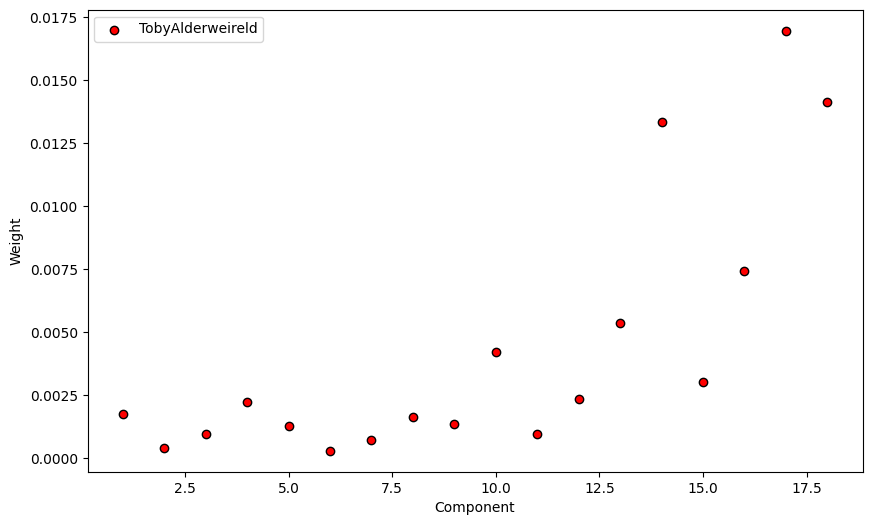

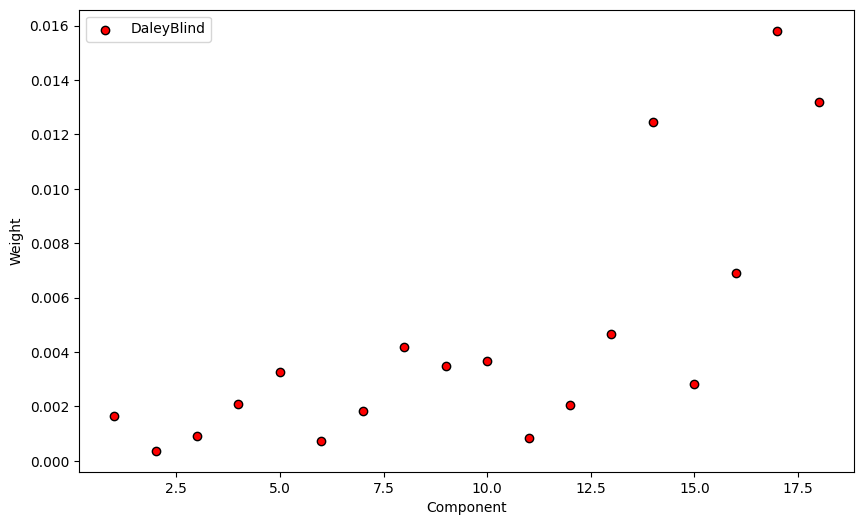

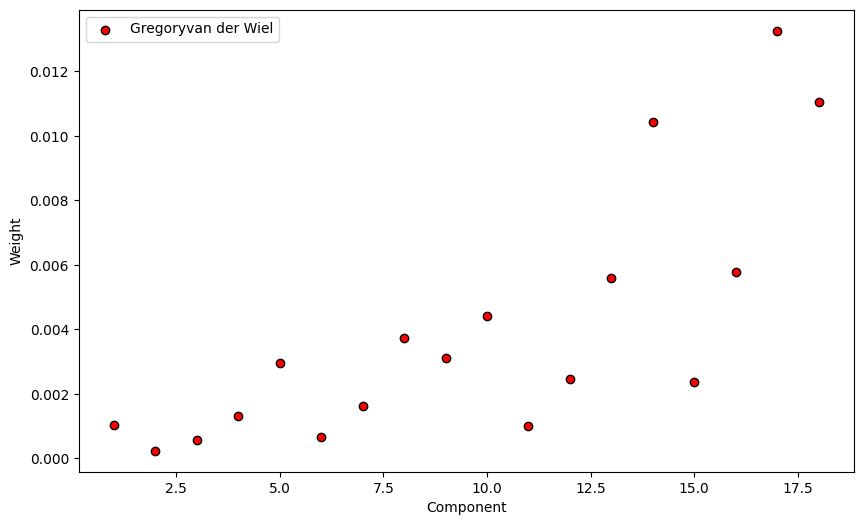

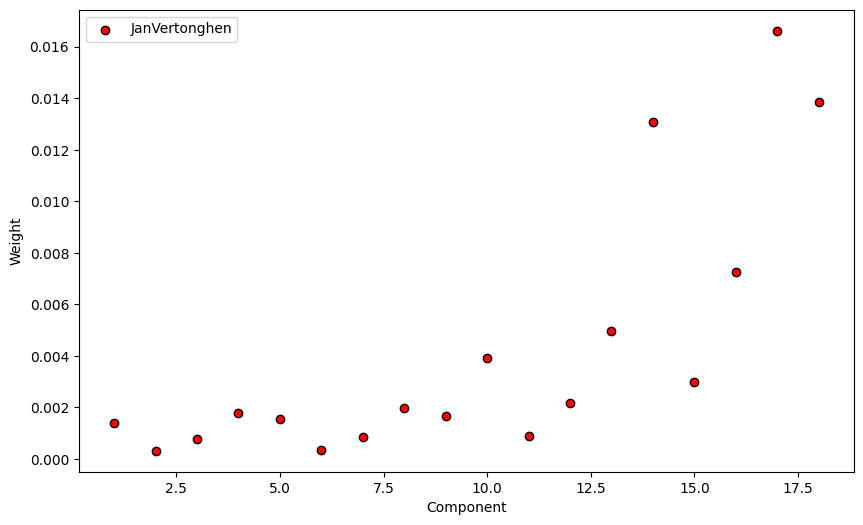

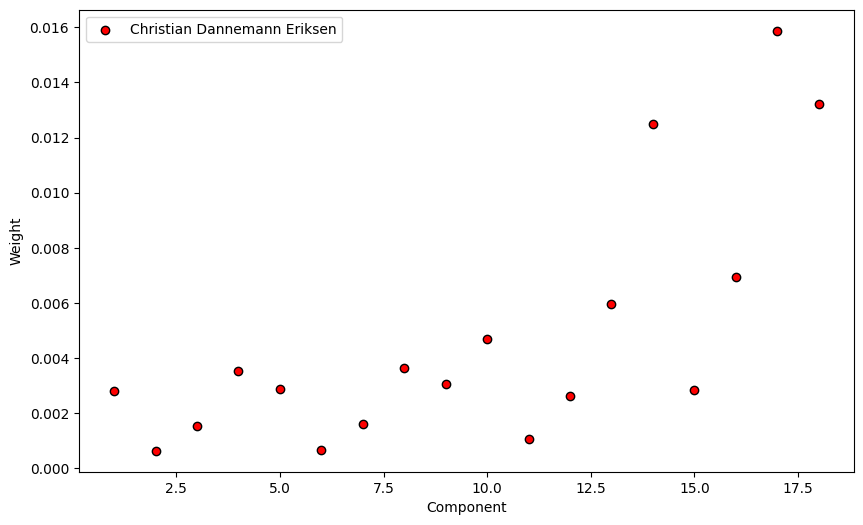

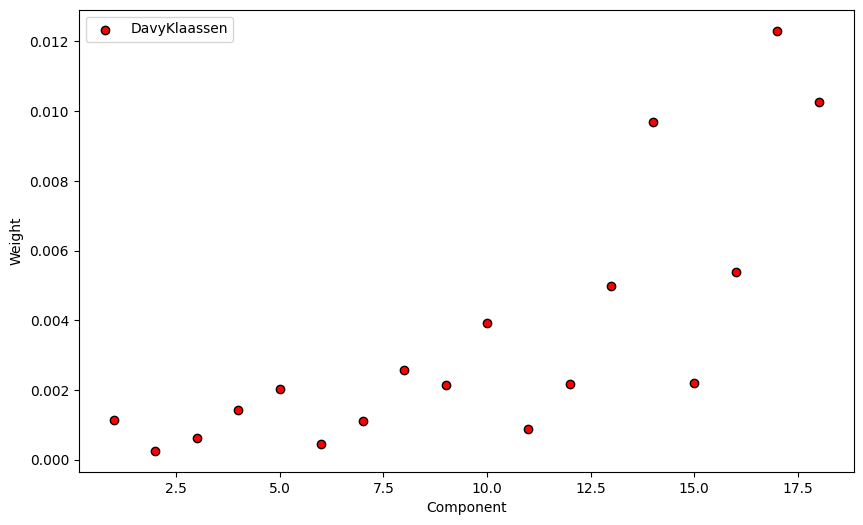

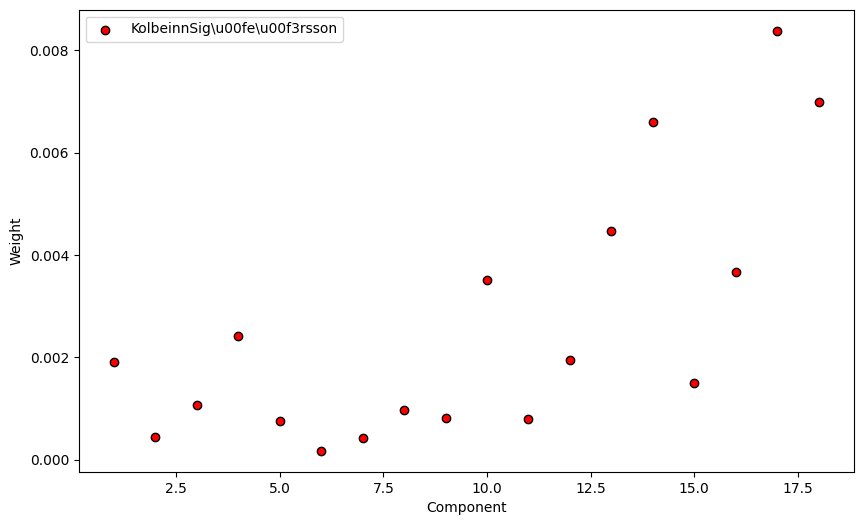

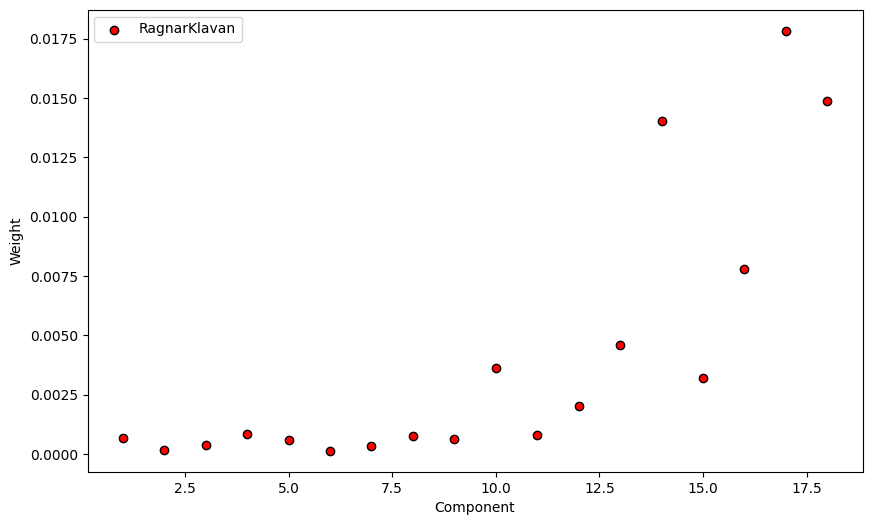

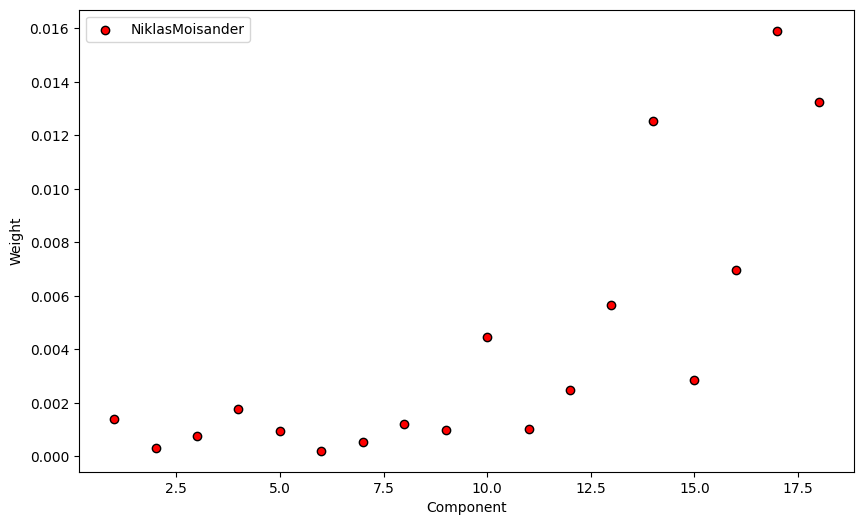

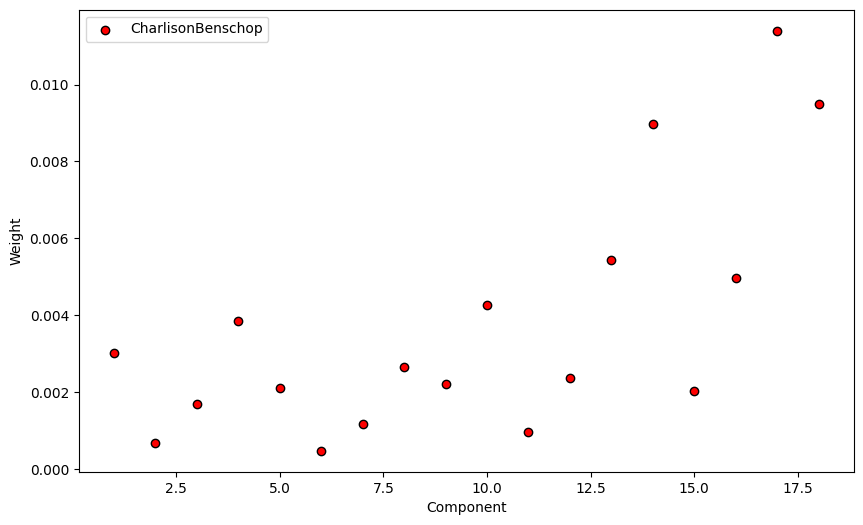

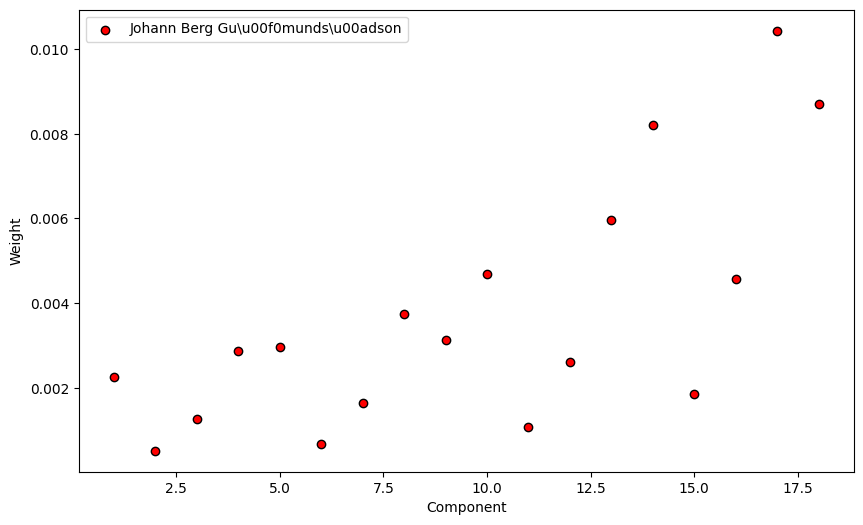

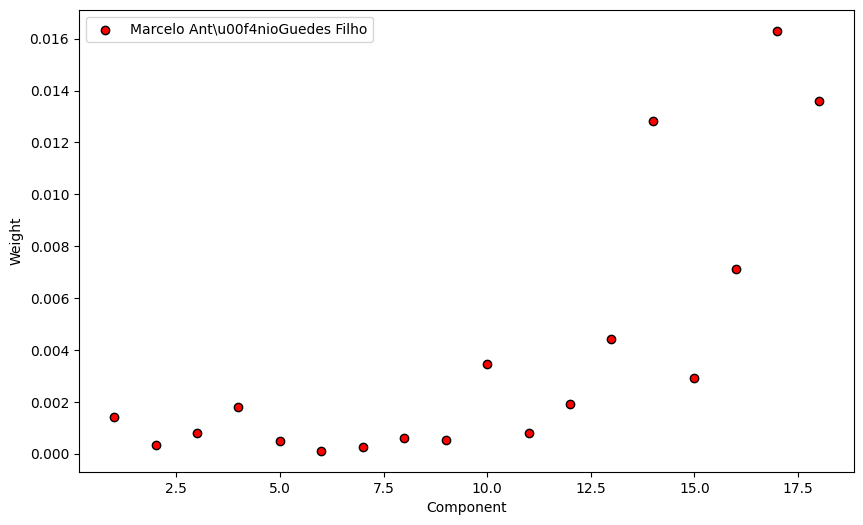

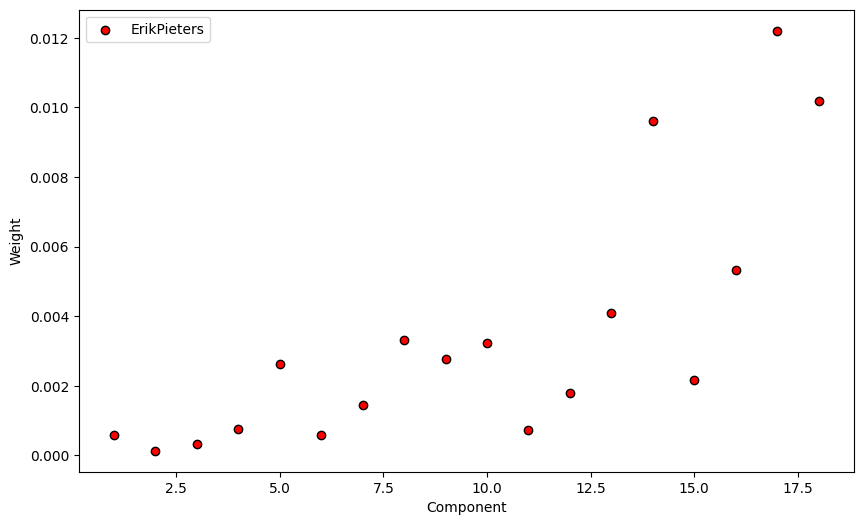

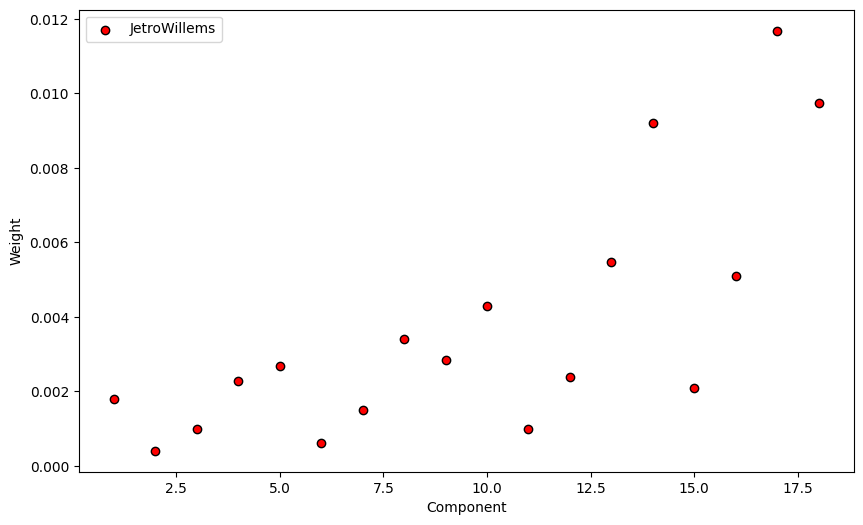

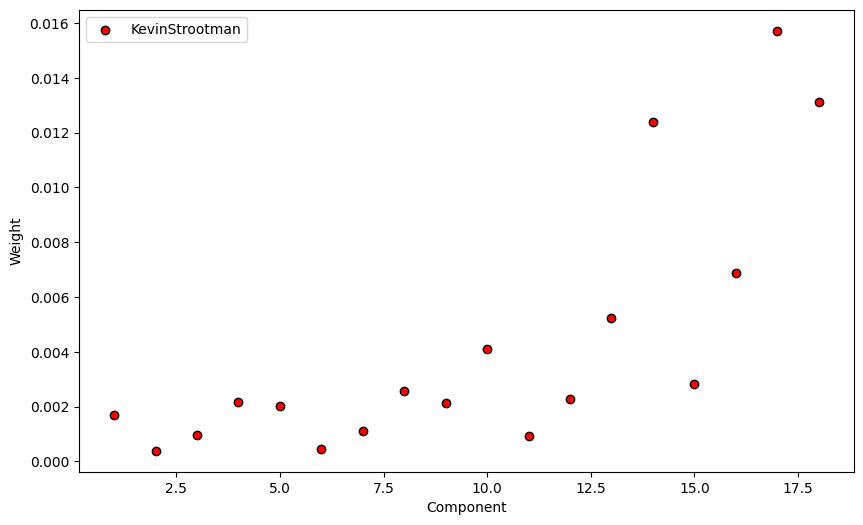

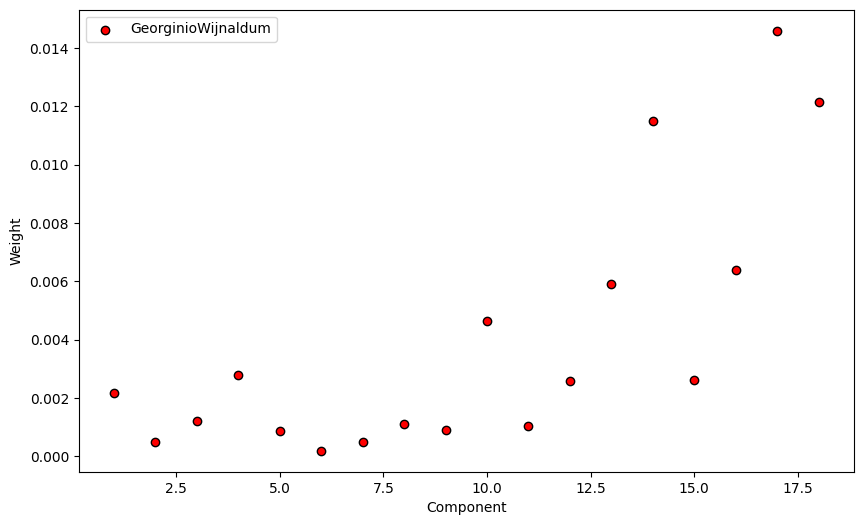

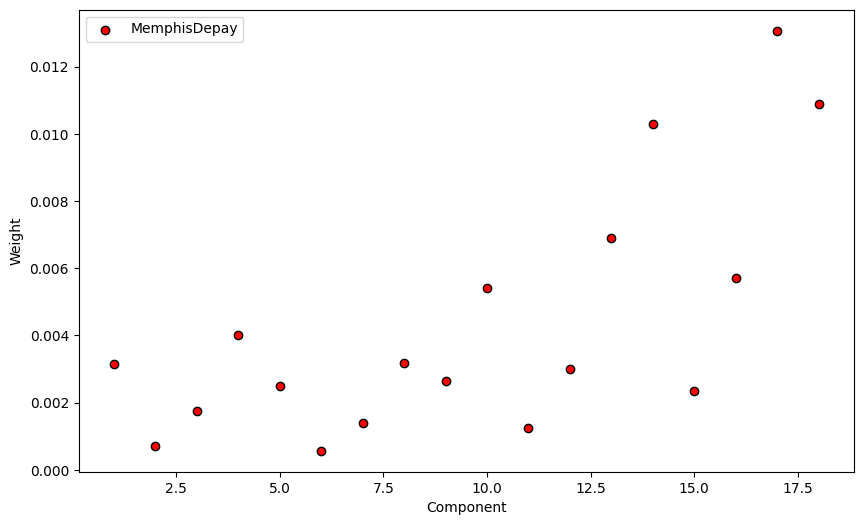

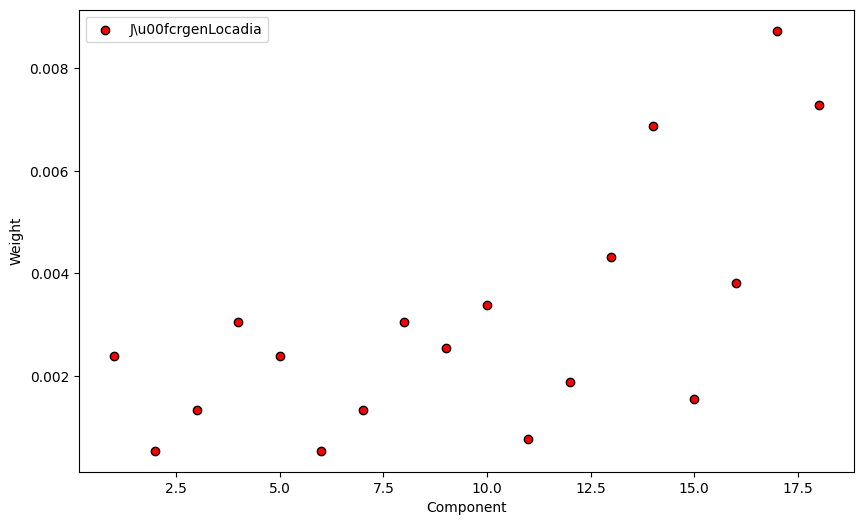

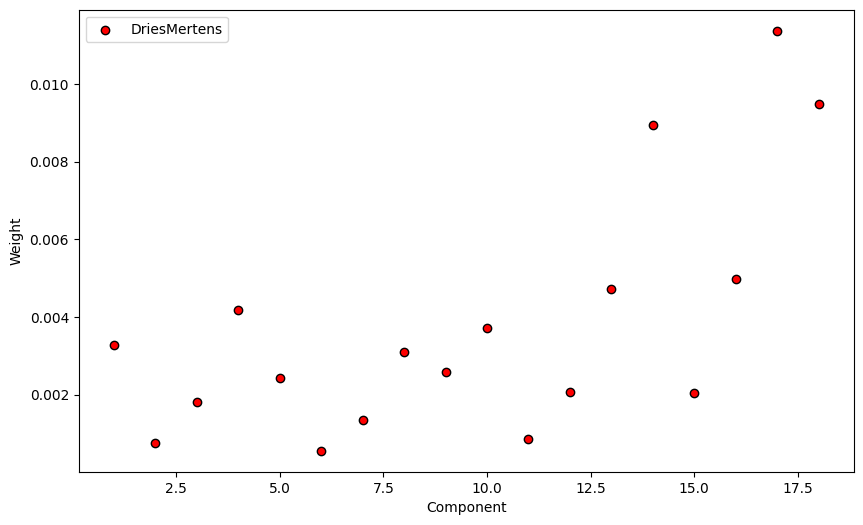

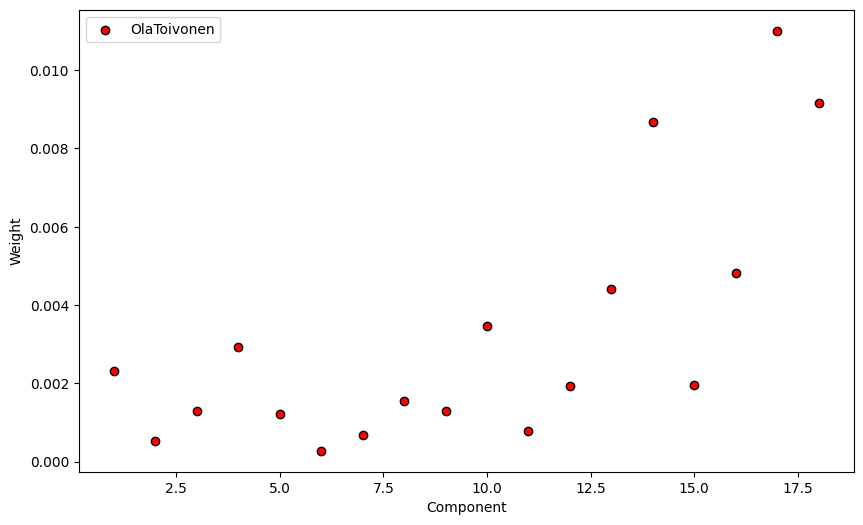

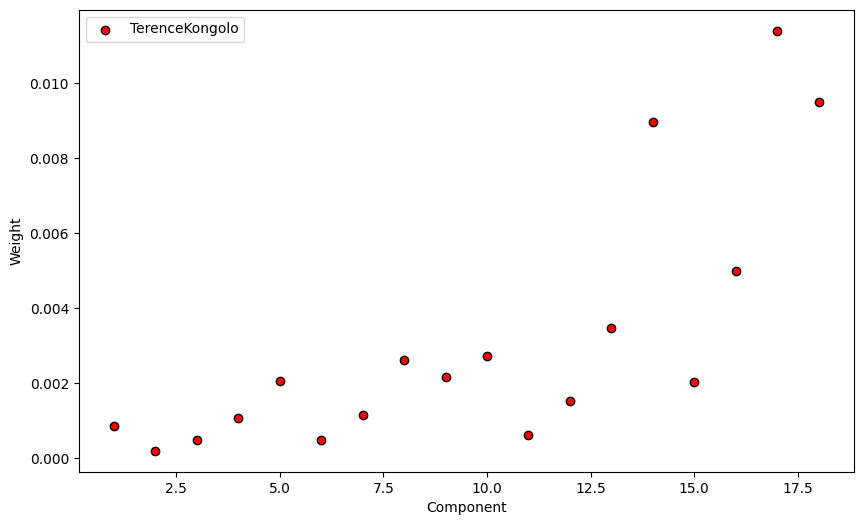

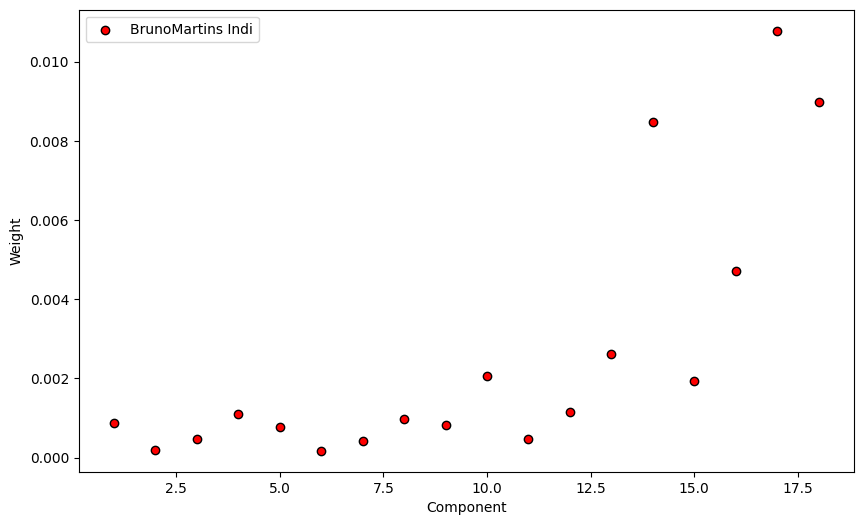

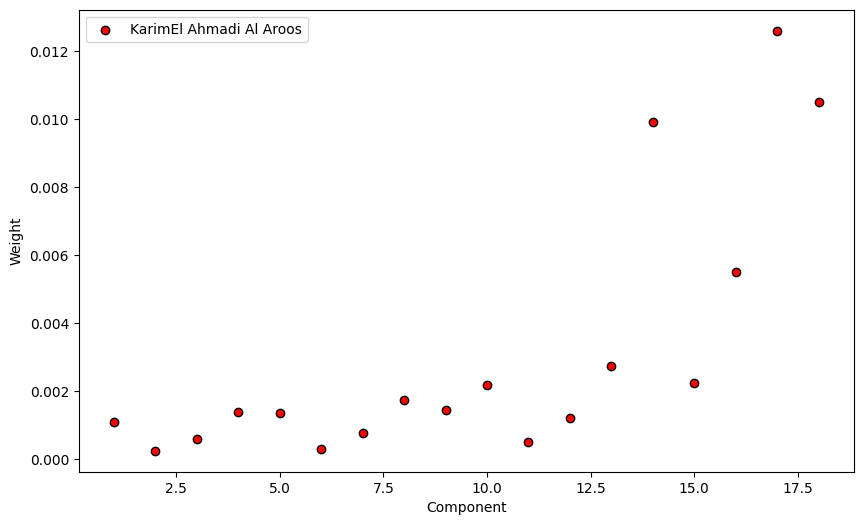

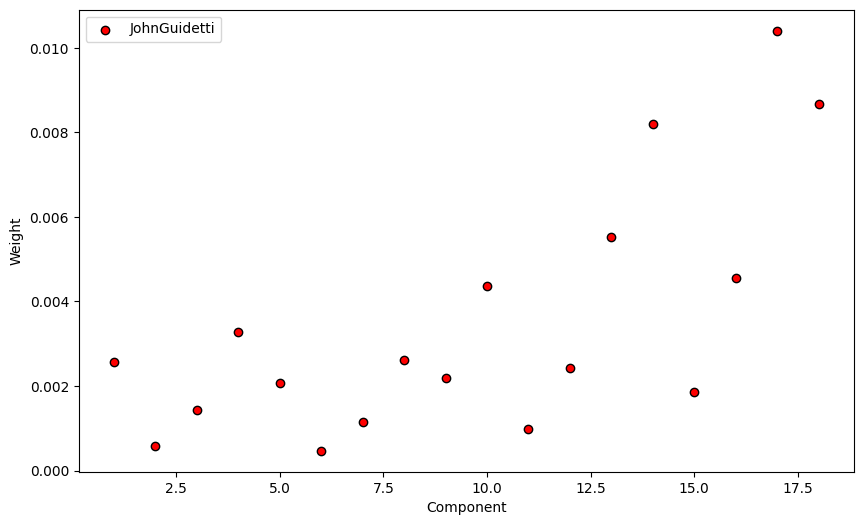

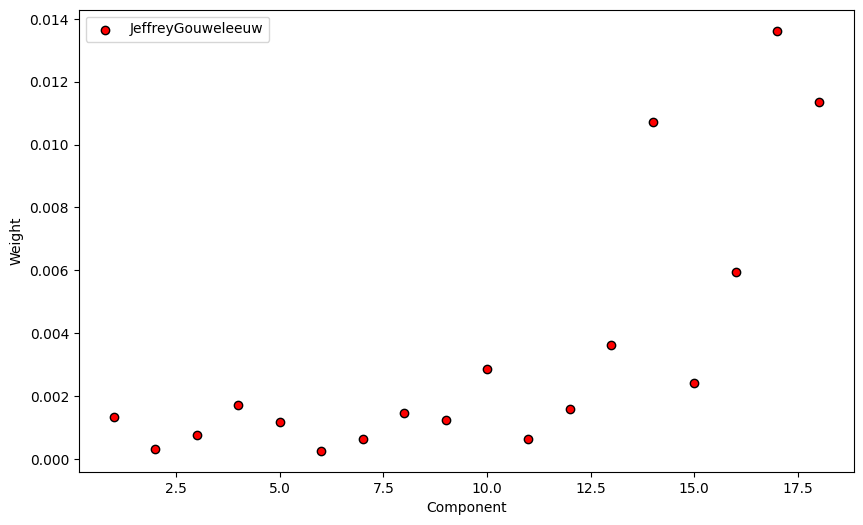

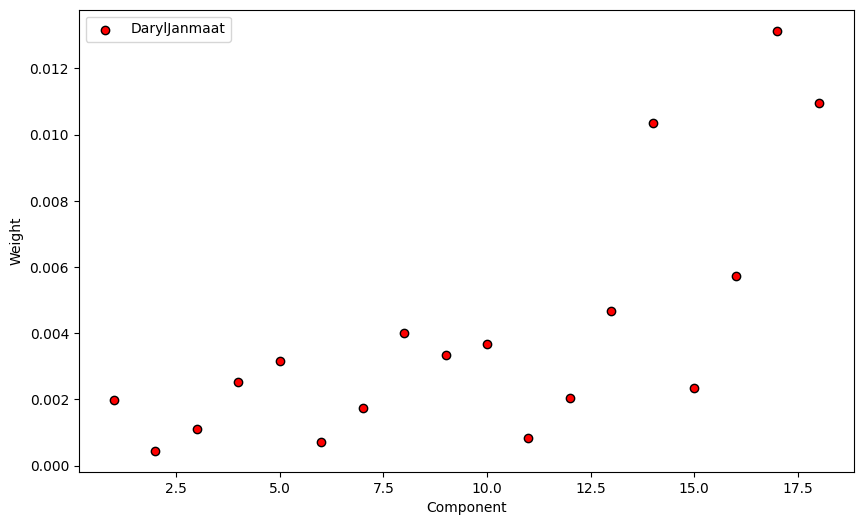

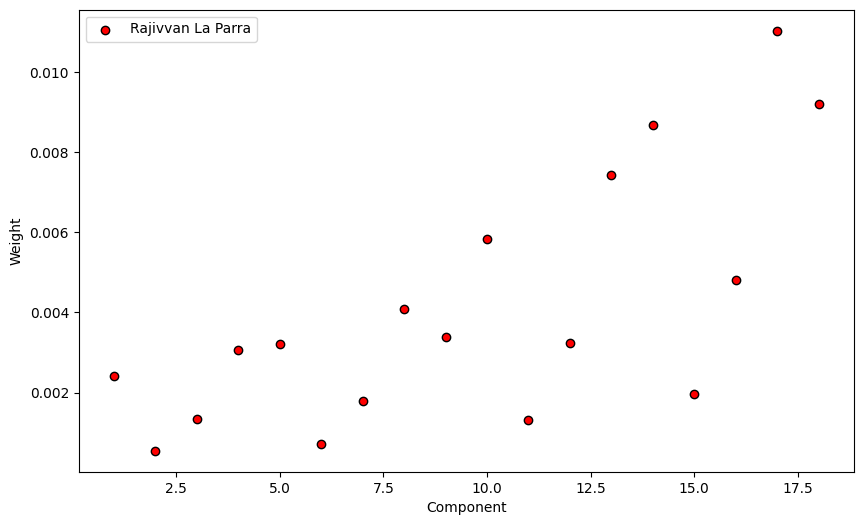

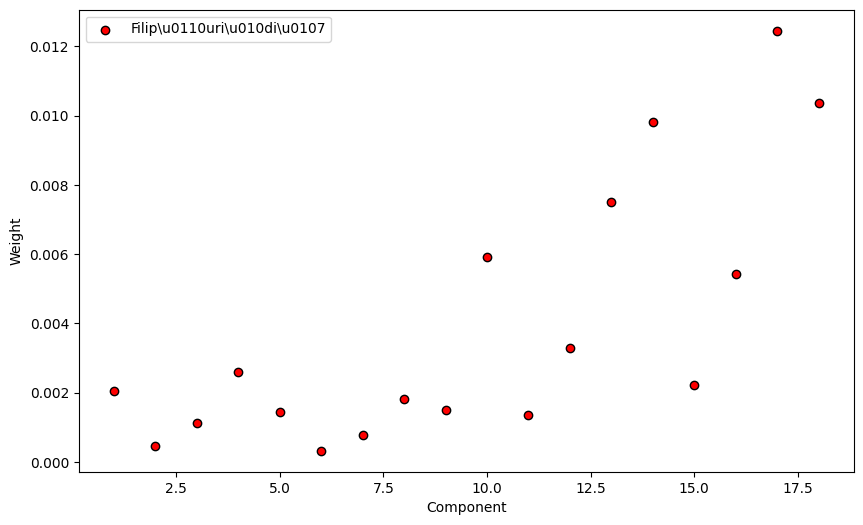

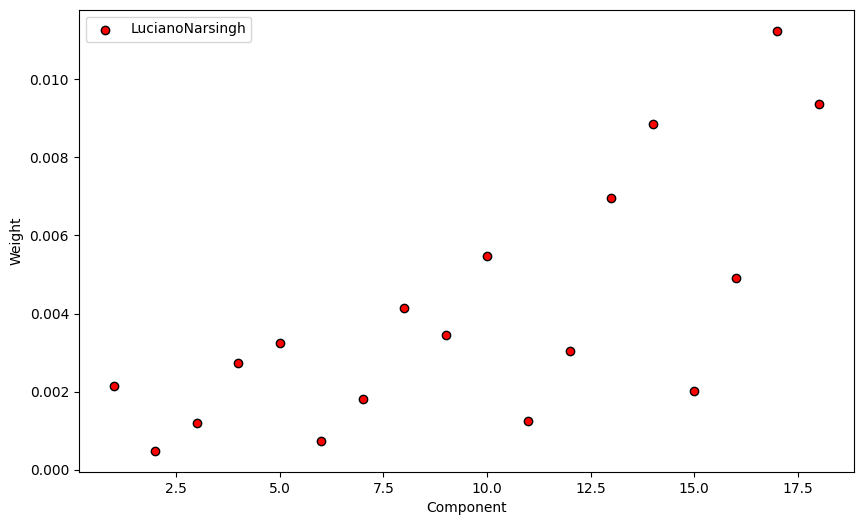

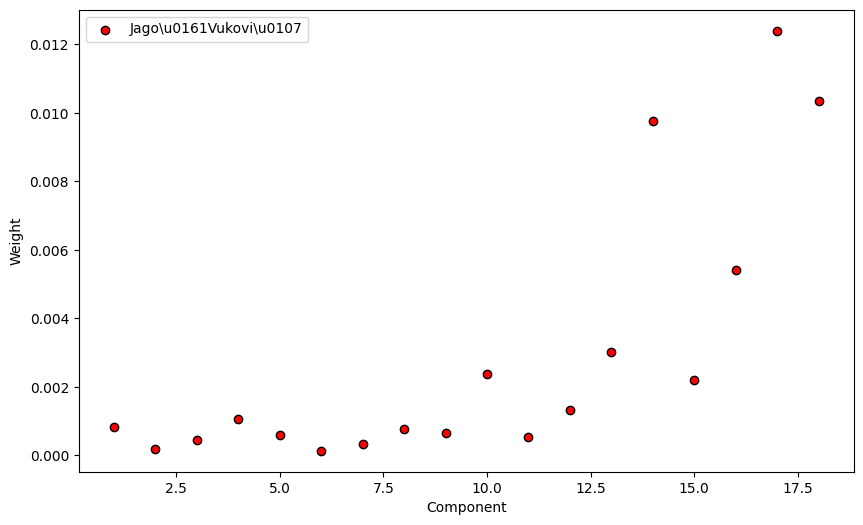

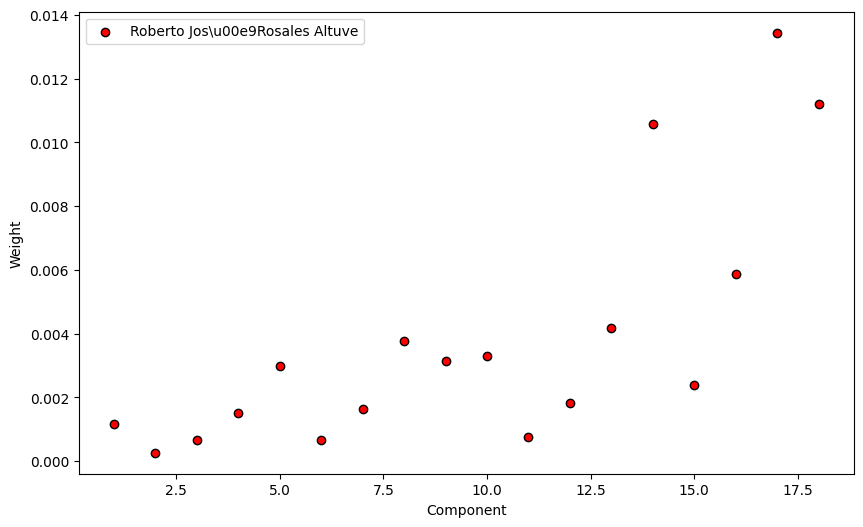

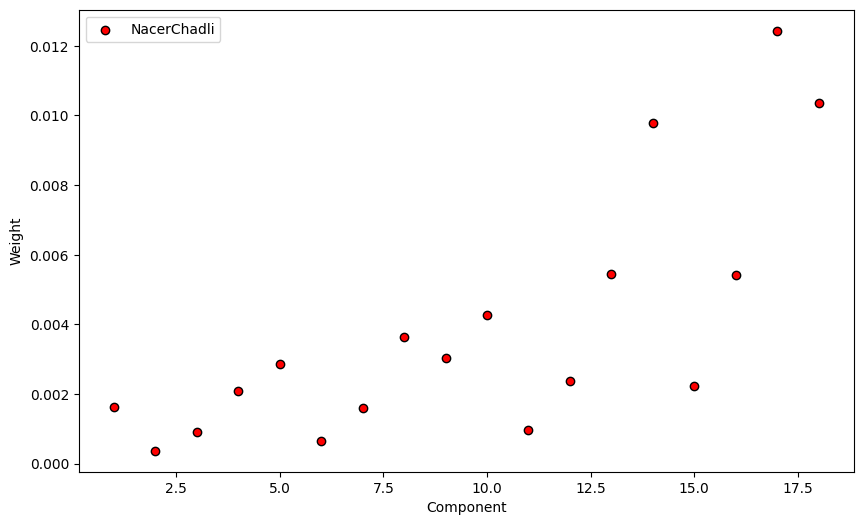

In [18]:
k_components = [_ for _ in range(1, 19)]
for num_plots, (playerID, components) in enumerate(playerIDs_to_vectors.items()):
    name = None 
    if playerID in players: 
        name = players[playerID][0] + players[playerID][1] 
    plt.figure(figsize=(10, 6))
    plt.xlabel('Component')
    plt.ylabel('Weight')
    plt.scatter(k_components,
                components,
                color='red',
                edgecolors='black',
                label=name)
    plt.legend()
    if num_plots > 30:
        break